In [11]:
# Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tensorflow as  tf
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pickle as pkl

In [5]:
financial_data = pd.read_csv("company_statistics.csv")
financial_data.head()

,Ticker,Name,Sector,Industry,IPO Year,Price,Market Cap,Trailing P/E,Forward P/E,PEG Ratio(5yr Expected),...,Operating Cash Flow(TTM),Levered Free Cash Flow(TTM),Beta(3Y Monthly),Shares Outstanding,Forward Annual Dividend Rate,Forward Annual Dividend Yield,Trailing Annual Dividend Rate,Trailing Annual Dividend Yield,5 Year Average Dividend Yield,Payout Ratio
0,PIH,"1347 Property Insurance Holdings, Inc.",Finance,Property-Casualty Insurers,2014.0,5.02,3.060500e+07,NaN,NaN,NaN,...,15660000.0,-2950000.0,0.38,6010000.0,NaN,NaN,NaN,NaN,NaN,0.00
1,TURN,180 Degree Capital Corp.,Finance,Finance/Investors Services,NaN,1.95,5.898600e+07,59.69,NaN,NaN,...,4350000.0,-2310000.0,0.66,31120000.0,NaN,NaN,NaN,NaN,NaN,0.00
2,FLWS,"1-800 FLOWERS.COM, Inc.",Consumer Services,Other Specialty Stores,1999.0,18.93,1.243000e+09,36.59,32.75,3.95,...,90770000.0,42390000.0,1.23,35770000.0,NaN,NaN,NaN,NaN,NaN,0.00
3,FCCY,1st Constitution Bancorp (NJ),Finance,Savings Institutions,NaN,17.62,1.562870e+08,11.18,10.15,1.38,...,NaN,NaN,0.16,8630000.0,0.30,1.65,0.30,1.68,NaN,17.59
4,SRCE,1st Source Corporation,Finance,Major Banks,NaN,44.97,1.171000e+09,13.80,12.59,1.25,...,130670000.0,NaN,1.38,25960000.0,1.08,2.43,0.52,1.16,1.95,31.04


Lets form our X and Y, which will consist of company statistics

In [8]:
to_remove = ['Ticker', 'Name', 'Price', 'Sector', 'Industry', 'IPO Year']
feature_cols = [x for x in financial_data.columns if x not in to_remove]
X = financial_data[feature_cols]
Y = financial_data['Price']

Now lets train an XGBRegressor Model on the data

In [7]:
data_dmatrix = xgb.DMatrix(data=X,label=Y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

In [13]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [14]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [15]:
xg_reg.score(X_test, y_test)
#print("Feature Importances: " + str(xg_reg.feature_importances_))

0.47270380065931106

In [16]:
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

param_test = {
    'max_depth':[3],
    'min_child_weight':[4],
    'learning_rate':[.25],
    'gamma':[0],
    'reg_alpha':[ 0.1, .12, .14]
}
xgbr = xgb.XGBRegressor() 
gsearch = GridSearchCV(estimator = xgbr , 
param_grid = param_test,n_jobs=4,iid=False, cv=5)
gsearch.fit(X_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

C:\Users\kevin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\kevin\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


([mean: 0.85424, std: 0.07623, params: {'gamma': 0, 'learning_rate': 0.25, 'max_depth': 3, 'min_child_weight': 4, 'reg_alpha': 0.1},
  mean: 0.85436, std: 0.07609, params: {'gamma': 0, 'learning_rate': 0.25, 'max_depth': 3, 'min_child_weight': 4, 'reg_alpha': 0.12},
  mean: 0.85313, std: 0.07619, params: {'gamma': 0, 'learning_rate': 0.25, 'max_depth': 3, 'min_child_weight': 4, 'reg_alpha': 0.14}],
 {'gamma': 0,
  'learning_rate': 0.25,
  'max_depth': 3,
  'min_child_weight': 4,
  'reg_alpha': 0.12},
 0.8543641380087227)

Now lets see how we did on the test set

In [17]:
gsearch.best_estimator_.score(X_test, y_test)

0.8972435939435452

In [18]:
model = gsearch.best_estimator_
preds = model.predict(X_test)

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, preds))

In [20]:
print("RMSE: %f" % (rmse))

RMSE: 19.172193


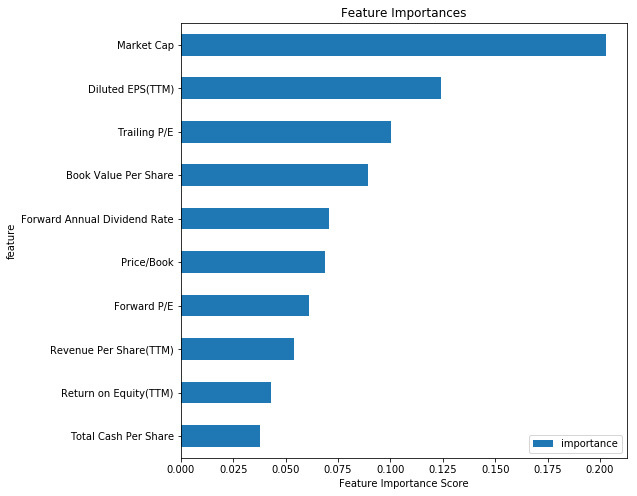

In [21]:
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    
    from xgboost.core     import XGBoostError
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (XGBoostError, ValueError):
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

fi = plot_feature_importances(model, X_train, y_train=y_train)

## Using XGBoost to Predict stock market prices given a companies summary statistics

In [22]:
from market import *

In [23]:
def predict_price(ticker): # Next Step: Compareto actual price and output how much its overvalued or undervalued by
    attributes = ['Market Cap (intraday)','Trailing P/E','Forward P/E','PEG Ratio (5 yr expected)','Price/Sales','Price/Book',
                  'Enterprise Value/Revenue','Enterprise Value/EBITDA','Profit Margin','Operating Margin',
                  'Return on Assets','Return on Equity','Revenue','Revenue Per Share',
                  'Quarterly Revenue Growth','Gross Profit','EBITDA','Diluted EPS',
                  'Quarterly Earnings Growth','Total Cash','Total Cash Per Share','Total Debt',
                  'Total Debt/Equity','Current Ratio','Book Value Per Share','Operating Cash Flow',
                  'Levered Free Cash Flow','Beta (3Y Monthly)','Shares Outstanding','Forward Annual Dividend Rate',
                  'Forward Annual Dividend Yield','Trailing Annual Dividend Rate','Trailing Annual Dividend Yield',
                  '5 Year Average Dividend Yield','Payout Ratio']
    stats = get_summary_statistics(ticker)
    x = []
    for a in attributes:
        x.append(str_to_num(stats[a]))
    to_remove = ['Ticker', 'Name', 'Price', 'Sector', 'Industry', 'IPO Year']
    feature_cols = [y for y in financial_data.columns if y not in to_remove]
    X = pd.DataFrame(columns=feature_cols)
    X.loc[-1] = x
    price = model.predict(X)
    return price[0]

In [24]:
predict_price("NVDA")

211.00438

In [25]:
analyze("NVDA")

ANALYSIS FOR NVDA
Industry: Semiconductors
Trailing P/E Ratio: 33.04. Industry Average: 40.71000000000001.
Forward P/E Ratio: 24.59. Industry Average: 18.99739130434783.
Price to Sales Ratio: 9.94. Industry Average: 8.569342105263159.
Price to Book Ratio: 10.99. Industry Average: 5.7200000000000015.
Enterprise Value to Revenue: 9.45. Industry Average: 7.238289473684211.
Enterprise Value to EBITDA: 32.05. Industry Average: 14.146842105263156.
Profit Margin: 30.67%. Industry Average: -2.574025974025973%.
Operating Margin: 26.72%. Industry Average: -8.169199999999998%.
Return on Assets: 14.06%. Industry Average: -4.160789473684211%.
Return on Equity: 37.78%. Industry Average: -11.639729729729726%.
Gross Profit: 7.17B. Industry Average: 1636469027.7777777.
Quarterly Earnings Growth: -68.30%. Industry Average: 25.051515151515165%.
Debt to Equity: 26.32. Industry Average: 55.19529411764708.
Current Ratio: 8.98. Industry Average: 4.71272727272727.
Book Value Per Share: 15.93. Industry Average

In [26]:
predict_price("WORK")

56.328915

In [27]:
analyze("WORK")

Failed to find the company industry.
ANALYSIS FOR WORK


TypeError: must be str, not int

Let's predict the price for Sony, which is outside of our training set.

In [115]:
portfolio = ['EIX', 'RCUS', 'DIS', 'ATVI', 'A', 'EA', 'IIPR']
predictions = []
for ticker in portfolio:
    predictions.append(predict_price(ticker))
print(predictions)

[49.56896, 11.598441, 157.96178, 46.519207, 62.09287, 85.7837, 76.2089]


In [1]:
predict_price("nvda")

NameError: name 'predict_price' is not defined

In [147]:
# save model to file
pkl.dump(model, open("xgbr_0725.dat", "wb"))

In [ ]:
model = pickle.load(open("xgbr_0725.dat", "rb"))

## Using a Neural Net to Predict Prices 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(20, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)
model.evaluate(X_test, y_test)

Epoch 1/5
1780/1780 [==============================] - 0s 181us/step - loss: nan - acc: 0.0000e+00
Epoch 2/5
1780/1780 [==============================] - 0s 29us/step - loss: nan - acc: 0.0000e+00
Epoch 3/5
1780/1780 [==============================] - 0s 31us/step - loss: nan - acc: 0.0000e+00
Epoch 4/5
1780/1780 [==============================] - 0s 31us/step - loss: nan - acc: 0.0000e+00
Epoch 5/5
446/446 [==============================] - 0s 190us/step


[nan, 0.0]